In [16]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Reducción de la dimensionalidad: PCA

Con la recopilación automática de datos y las técnicas de generación de características, se puede obtener rápidamente un gran número de características. Pero no todas son útiles. Esto no solo vuelve el entrenamiento extremadamente lento, sino que también puede dificultar mucho encontrar una buena solución, como veremos. A este problema se le suele llamar la *maldición de la dimensionalidad*.

Hablamos de filtrado y de escalado de características como formas de podar características poco informativas. Ahora examinaremos en detalle el tema de la reducción de la dimensionalidad de las características mediante el **análisis de componentes principales (PCA)**.

## Enfoques principales para la reducción de la dimensionalidad

Antes de entrar en algoritmos concretos de reducción de la dimensionalidad, veamos los dos enfoques principales para reducirla.

### Proyección

En la mayoría de los problemas del mundo real, las instancias de entrenamiento no se distribuyen de forma uniforme en todas las dimensiones. Muchas características son casi constantes, mientras que otras están altamente correlacionadas. Como resultado, todas las instancias de entrenamiento yacen en (o cerca de) un subespacio de **mucho menor dimensión** dentro del espacio de alta dimensión.


In [17]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

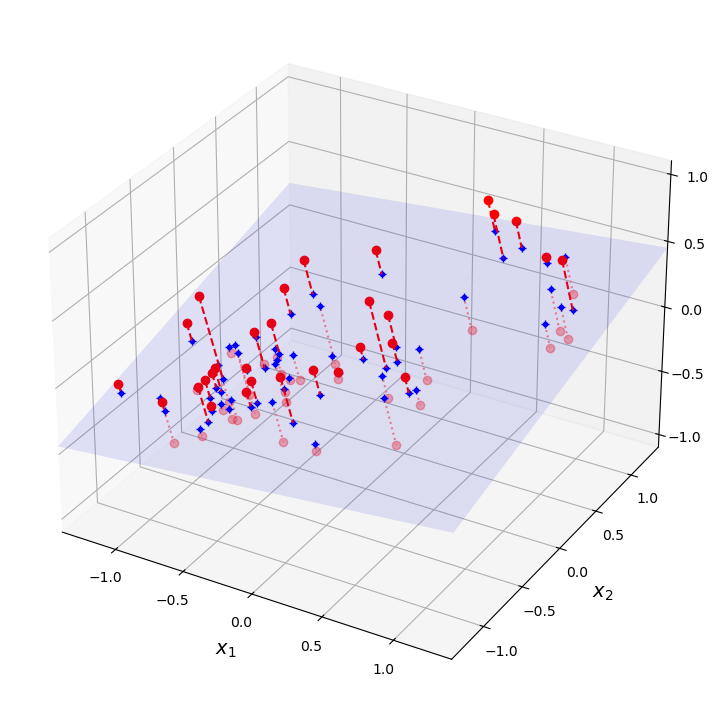

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

plt.show()

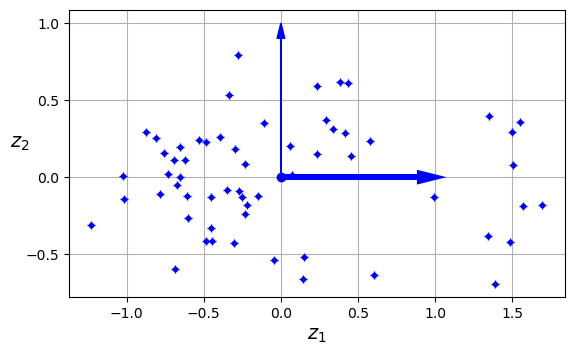

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)
plt.show()

Sin embargo, la proyección no siempre es el mejor enfoque para la reducción de la dimensionalidad. En muchos casos, el subespacio puede retorcerse y curvarse, como en el famoso conjunto de datos *Swiss roll*.


In [20]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1500, noise=0.2, random_state=42)



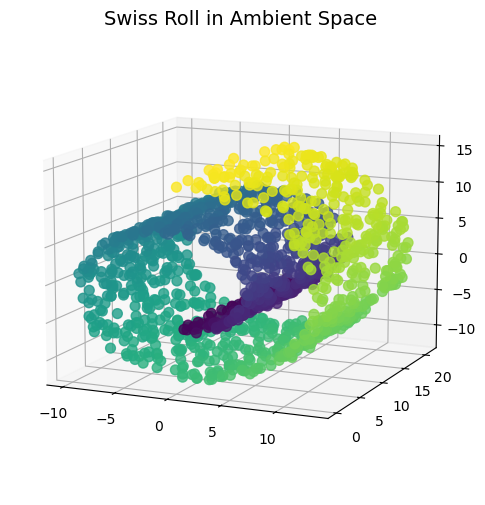

In [21]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, s=50, alpha=0.8
)
ax.set_title("Swiss Roll in Ambient Space")
ax.view_init(azim=-66, elev=12)


### Manifold Learning

Una variedad 2D es una forma bidimensional que puede doblarse y retorcerse en un espacio de mayor dimensión. Más en general, una variedad de dimensión $d$ es una parte de un espacio de dimensión $n$ (donde $d < n$) que localmente se asemeja a un hiperplano de dimensión $d$. En el caso del *Swiss roll*, $d = 2$ y $n = 3$: localmente se parece a un plano 2D, pero está enrollado en la tercera dimensión.

Muchos algoritmos de reducción de la dimensionalidad funcionan modelando la variedad sobre la que se sitúan las instancias de entrenamiento; a esto se le llama **manifold learning**. Se basa en la **suposición de variedad** (o **hipótesis de variedad**), que sostiene que la mayoría de los conjuntos de datos de alta dimensionalidad del mundo real yacen cerca de una variedad de dimensión mucho menor. Esta suposición se observa con mucha frecuencia de forma empírica.

A menudo, la suposición de variedad viene acompañada de otra suposición implícita: que la tarea en cuestión (p. ej., clasificación o regresión) será más sencilla si se expresa en el espacio de menor dimensión de la variedad.

Sin embargo, esta suposición no siempre se cumple.

En resumen, si reduces la dimensionalidad de tu conjunto de entrenamiento antes de entrenar un modelo, por lo general **acelerarás** el entrenamiento, pero no siempre obtendrás una solución **mejor o más simple**; todo depende del conjunto de datos.


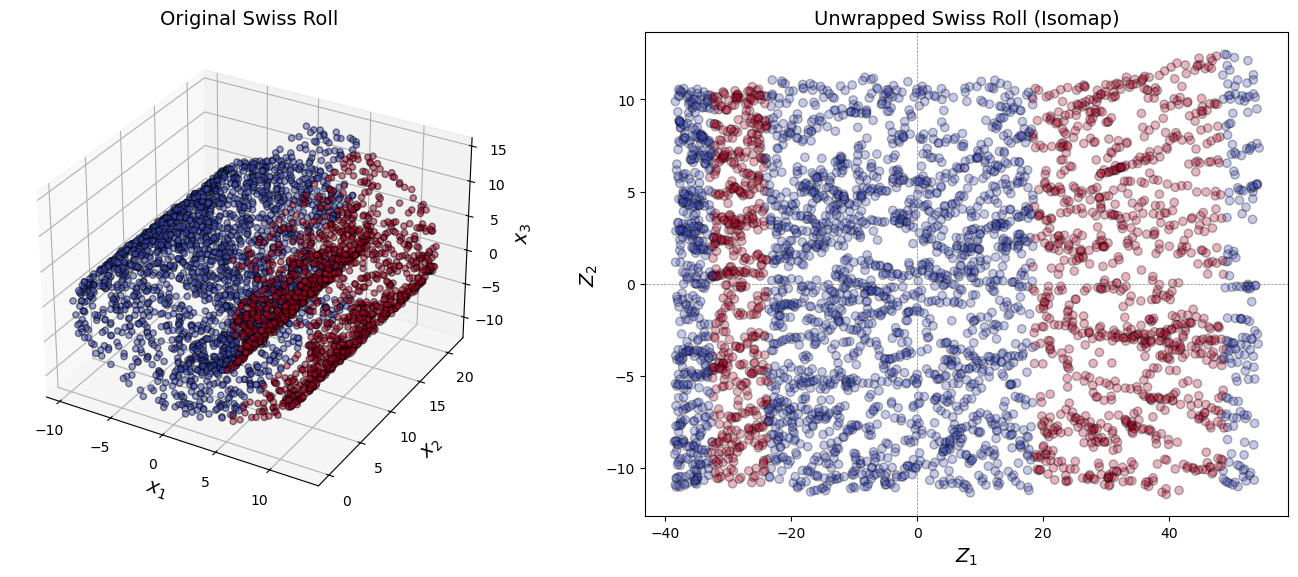

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import Isomap
from mpl_toolkits.mplot3d import Axes3D

# Generate Swiss Roll dataset
n_samples = 4000
X, _ = make_swiss_roll(n_samples=n_samples, noise=0.1)

# Create class labels based on the plane x1 = 5
labels = (X[:, 0] > 5).astype(int)

# Apply Isomap for dimensionality reduction
isomap = Isomap(n_neighbors=10, n_components=2)
X_isomap = isomap.fit_transform(X)

# Create figure
fig = plt.figure(figsize=(14, 6))

# 1. Original Swiss Roll with class separation
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap=plt.cm.coolwarm, edgecolor='k', alpha=0.5)
ax1.set_title("Original Swiss Roll ")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.set_zlabel("$x_3$")



# 2. Unwrapped Swiss Roll using Isomap with class separation
ax2 = fig.add_subplot(122)
scatter2 = ax2.scatter(X_isomap[:, 0], X_isomap[:, 1], c=labels, cmap=plt.cm.coolwarm, edgecolor='k', alpha=0.3)
ax2.set_title("Unwrapped Swiss Roll (Isomap)")
ax2.set_xlabel("$Z_1$")
ax2.set_ylabel("$Z_2$")
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax2.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

# Show the plots
plt.tight_layout()
plt.show()


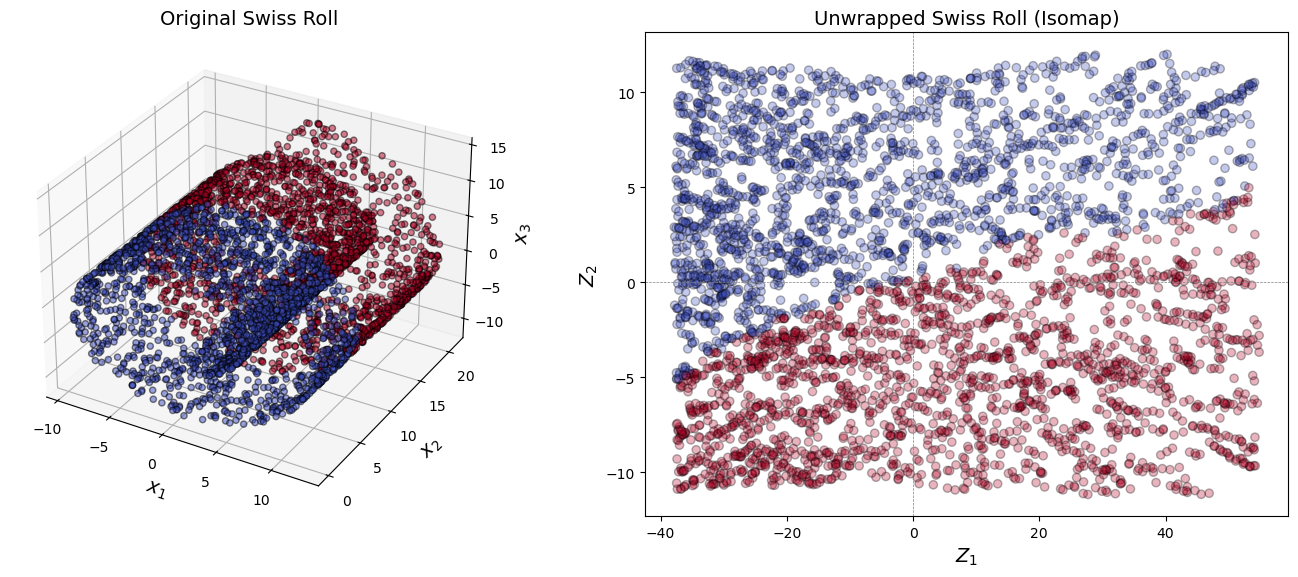

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import Isomap
from mpl_toolkits.mplot3d import Axes3D

# Generate Swiss Roll dataset
n_samples = 4000
X, t = make_swiss_roll(n_samples=n_samples)

# Create class labels 
labels = (t + X[:, 1] > np.median(t + X[:, 1])).astype(int)

# Apply Isomap for dimensionality reduction
isomap = Isomap(n_neighbors=10, n_components=2)
X_isomap = isomap.fit_transform(X)

# Create figure
fig = plt.figure(figsize=(14, 6))

# 1. Original Swiss Roll with class separation
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap=plt.cm.coolwarm, edgecolor='k', alpha=0.5)
ax1.set_title("Original Swiss Roll ")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.set_zlabel("$x_3$")



# 2. Unwrapped Swiss Roll using Isomap with class separation
ax2 = fig.add_subplot(122)
scatter2 = ax2.scatter(X_isomap[:, 0], X_isomap[:, 1], c=labels, cmap=plt.cm.coolwarm, edgecolor='k', alpha=0.3)
ax2.set_title("Unwrapped Swiss Roll (Isomap)")
ax2.set_xlabel("$Z_1$")
ax2.set_ylabel("$Z_2$")
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax2.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

# Show the plots
plt.tight_layout()
plt.show()


## PCA

PCA es, con diferencia, el algoritmo de reducción de la dimensionalidad más popular y se centra en la noción de **dependencia lineal**.

Las características linealmente dependientes son un desperdicio de espacio y de potencia de cómputo, porque la información podría haberse codificado con muchas menos características.

La idea clave aquí es reemplazar las características redundantes por unas pocas nuevas características que resuman adecuadamente la información contenida en el espacio original de características.

### Preservar la varianza

Una manera de definir matemáticamente «resumir adecuadamente la información» consiste en que, antes de proyectar el conjunto de entrenamiento sobre un hiperplano de menor dimensión, elijas el hiperplano **adecuado**, es decir, aquel con el que se pierda la menor cantidad de información.

Parece razonable seleccionar los ejes que conserven la mayor parte posible del volumen original. Para medir dicho “volumen”, podríamos considerar la distancia máxima entre cualquier par de puntos, pero esa función resulta muy difícil de optimizar.

Una alternativa es medir la distancia media entre pares de puntos o, de forma equivalente, la distancia media de cada punto a su media, que es la **varianza**. Esto resulta mucho más sencillo de optimizar.

> Matemáticamente, esto se traduce en maximizar la varianza de los puntos de datos en el nuevo espacio de características.


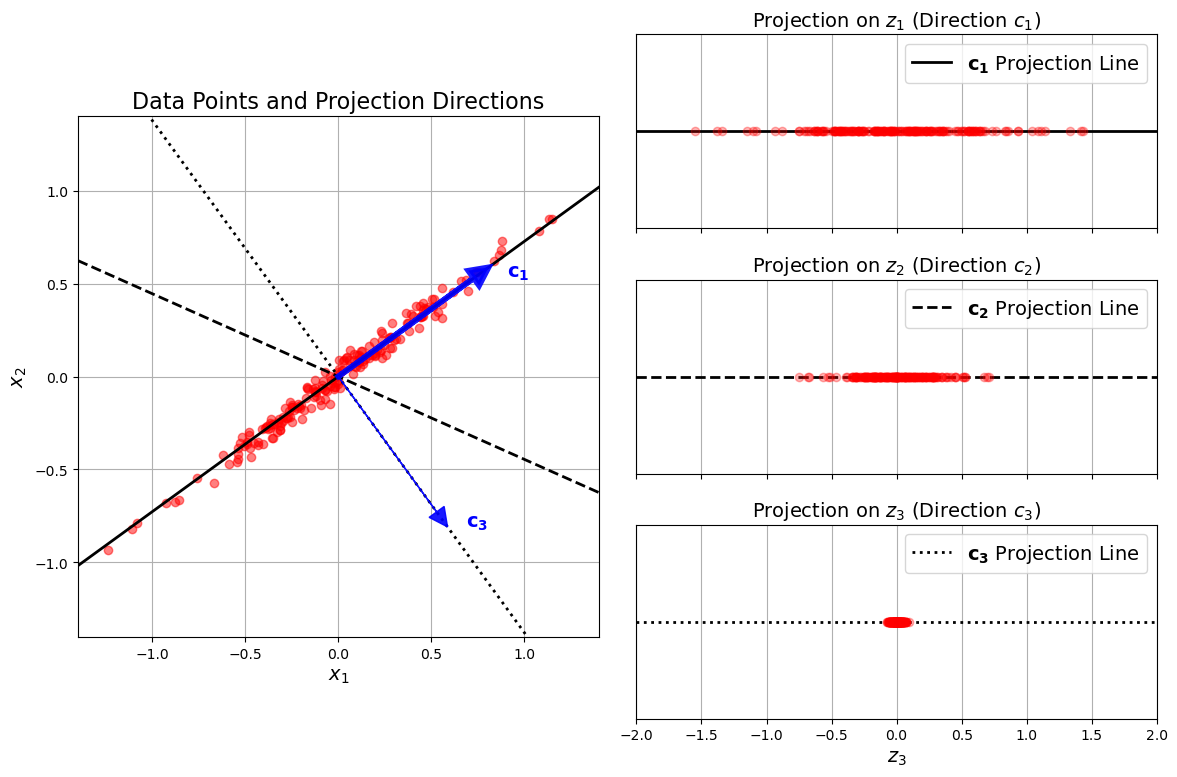

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
angle = np.pi / 5
stretch = 5
m = 200

# Generate random data
np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # Stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # Rotate

# Define projection directions
u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

# Project data onto the defined directions
X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

# Create the figure
plt.figure(figsize=(12, 8))

# 1. Scatter plot of the original data and projection directions (Square Aspect Ratio)
ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5, label='Data Points')
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)

# Plotting projection lines
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-", linewidth=2, label=r"$\mathbf{c_1}$ Direction")
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--", linewidth=2, label=r"$\mathbf{c_3}$ Direction")
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:", linewidth=2, label=r"$\mathbf{c_2}$ Direction")

# Annotations
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_3}$", color="blue")

# Labels and aesthetics
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Data Points and Projection Directions", fontsize=16)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()
ax1.set_aspect('equal', adjustable='box')  # Set square aspect ratio

# 2. Projected data along u1
ax2 = plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2, label=r"$\mathbf{c_1}$ Projection Line")
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.title("Projection on $z_1$ (Direction $c_1$)", fontsize=14)
plt.grid()
plt.legend()

# 3. Projected data along u2
ax3 = plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2, label=r"$\mathbf{c_2}$ Projection Line")
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.title("Projection on $z_2$ (Direction $c_2$)", fontsize=14)
plt.grid()
plt.legend()

# 4. Projected data along u3
ax4 = plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2, label=r"$\mathbf{c_3}$ Projection Line")
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_3$", fontsize=14)
plt.title("Projection on $z_3$ (Direction $c_3$)", fontsize=14)
plt.grid()
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


### Componentes principales

PCA identifica el eje que explica la mayor cantidad de varianza en el conjunto de entrenamiento. También encuentra un segundo eje, ortogonal al primero, que explica la mayor parte de la varianza restante.

En el ejemplo 2D anterior no hay alternativa: es la línea de puntos.

Si se tratara de un conjunto de datos de mayor dimensión, PCA también encontraría un tercer eje, ortogonal a los dos anteriores, y un cuarto, un quinto, y así sucesivamente—tantos ejes como dimensiones tenga el conjunto de datos.

> El vector unitario que define el eje $i$-ésimo se denomina **componente principal** $i$-ésimo (PC).

### Descomposición en valores singulares

¿Cómo podemos encontrar los componentes principales de un conjunto de entrenamiento? La forma más sencilla de implementar PCA es realizando la **descomposición en valores singulares** (SVD) de la matriz de datos centrada.

La SVD es una técnica estándar de factorización matricial que puede descomponer la matriz del conjunto de entrenamiento $X$ en el producto de tres matrices $U$, $\Sigma$ y $V^T$, donde $V$ contiene todos los componentes principales que buscamos:

$$
    V = \Bigg( c_1 \; c_2 \; \dots \; c_n \Bigg) 
$$

$U$ y $V$ son matrices ortogonales (es decir, $U^TU = I$ y $V^TV = I$). $\Sigma$ es una matriz diagonal que contiene los valores singulares de $X$, que pueden ser positivos, cero o negativos.


In [25]:
import numpy as np

# X = [...]  # the small 3D dataset was created earlier in this notebook
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

> En principio, el algoritmo de factorización SVD devuelve tres matrices, $U$, $\Sigma$ y $V$, donde $U$ es una matriz $m\times m$, $\Sigma$ es una matriz $m\times n$ y $V$ es una matriz $n\times n$. Pero la función `svd()` devuelve $U$, $s$ y $V^T$ en su lugar. $s$ es el vector que contiene todos los valores de la diagonal principal de las $n$ primeras filas de $\Sigma$. Dado que $\Sigma$ está llena de ceros en el resto, puedes reconstruirla fácilmente a partir de $s$, así:


In [26]:
# how to construct Σ from s
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)

### Proyección a $k$ dimensiones

Una vez que has identificado todos los componentes principales, puedes reducir la dimensionalidad del conjunto de datos a $k$ dimensiones proyectándolo sobre el **hiperplano** definido por los primeros $k$ componentes principales. Seleccionar este hiperplano garantiza que la proyección **conserve** la mayor varianza posible.

Para proyectar el conjunto de entrenamiento sobre el hiperplano, basta con calcular la **multiplicación matricial** de la matriz de datos $X$ por la matriz $V_k$, definida como la matriz que contiene los primeros $k$ componentes principales (es decir, las **primeras $k$ columnas** de $V$):

$$
Z = X V_k = U\Sigma V^T V_k = U_k \Sigma_k
$$


In [27]:
W2 = Vt[:2].T
X2D = X_centered.dot(W2)

### Resumen de implementación de PCA

| Paso                                         | Descripción                                                                                                                                                                                            |
| -------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **1. Centrar la matriz de datos**            | Centra la matriz de datos $C$ restando la media: $C = X - \mathbf{1}\mu^T$, donde $\mathbf{1}$ es un vector columna de unos y $\mu$ es el vector media de las filas de $X$.                            |
| **2. Calcular la SVD**                       | Realiza la Descomposición en Valores Singulares (SVD) sobre la matriz centrada $C$: $C = U\Sigma V^T$.                                                                                                 |
| **3. Encontrar los componentes principales** | Los primeros $k$ componentes principales son las primeras $k$ columnas de $V$, correspondientes a los $k$ mayores valores singulares.                                                                  |
| **4. Transformar los datos**                 | Los datos transformados vienen dados por las primeras $k$ columnas de $U$. (Para el *whitening*, escala los vectores por el inverso de los valores singulares, asegurando que sean distintos de cero). |


### Uso de Scikit-Learn

Con Scikit-Learn, la PCA es realmente trivial. Incluso se encarga del centrado respecto a la media por ti:


In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
pca.components_

array([[ 4.85716767e-01, -5.09943009e-04,  8.74116103e-01],
       [ 8.67330075e-01, -1.24083900e-01, -4.82018389e-01]])

### Selección de componentes principales

Al usar PCA para la **reducción de la dimensionalidad**, hay que responder a la pregunta de cuántos **componentes principales** ($k$) utilizar. Como todo hiperparámetro, este número puede ajustarse según la calidad del modelo resultante. Pero también existen **heurísticas** que no requieren métodos computacionalmente costosos.

Una posibilidad es elegir $k$ para cubrir una **proporción deseada de la varianza total** (esta opción está disponible en la implementación de PCA de scikit-learn). La varianza de la **proyección** sobre el $k$-ésimo componente (también llamada **proporción de varianza explicada**) es:

$$
\lVert X\mathbf{v_k} \rVert^2 = \lVert \mathbf{u_k}\sigma_k \rVert^2 = \sigma_k^2 
$$

que es el cuadrado del $k$-ésimo mayor **valor singular** de $X$.

#### Selección de $k$ basada en la varianza explicada

La lista ordenada de los valores singulares de una matriz se denomina **espectro**. Así, para determinar cuántos componentes usar, puede realizarse un análisis espectral sencillo de la matriz de datos y escoger el umbral que **retenga suficiente varianza**.

> Para retener componentes que cubran el 80 % de la varianza total en los datos, elige $k$ tal que:
>
> $\frac{\sum_{i=1}^k \sigma_i^2}{\sum_{i=1}^d \sigma_i^2} \ge 0.8$

A menos que estemos **reduciendo la dimensionalidad para visualización de datos**: en ese caso, generalmente se desea reducirla a **2 o 3** dimensiones.


In [29]:
pca.explained_variance_ratio_

array([0.39453645, 0.31930836])

La primera dimensión explica alrededor del 76 % de la varianza, mientras que la segunda explica alrededor del 15 %.

Al proyectar a 2D, perdimos aproximadamente el 9 % de la varianza:


In [30]:
1 - pca.explained_variance_ratio_.sum() 

0.28615518940413565

## Ejemplo de código: conjunto de datos MNIST

In [31]:
from sklearn import datasets
from sklearn.decomposition import PCA

# Load the data
digits_data = datasets.load_digits()
n = len(digits_data.images)



image shape: (1797, 64)


El conjunto de datos MNIST contiene imágenes de dígitos manuscritos. Cada imagen es un arreglo de 8×8 con valores de píxel. Aplanamos estos arreglos a vectores unidimensionales para prepararlos para PCA.

### Aplicación de PCA al conjunto de datos


In [ ]:
image_data = digits_data.images.reshape((n, -1))
print('image shape:', image_data.shape)

En esta sección, ajustamos PCA a los datos de imágenes aplanadas, seleccionando suficientes componentes para explicar al menos el 80 % de la varianza. Luego examinamos la proporción de varianza explicada para entender cuánta información retienen los componentes principales.

In [32]:
# Fit a PCA transformer to the dataset.
# The number of components is automatically chosen to account for 
# at least 80% of the total variance.
pca_transformer = PCA(n_components=0.8)
pca_images = pca_transformer.fit_transform(image_data)
pca_transformer.explained_variance_ratio_

array([0.14890594, 0.13618771, 0.11794594, 0.08409979, 0.05782415,
       0.0491691 , 0.04315987, 0.03661373, 0.03353248, 0.03078806,
       0.02372341, 0.02272697, 0.01821863])

In [33]:
pca_transformer.explained_variance_ratio_.sum()

0.8028957761040316

In [35]:
# Groundtruth label of the number appearing in each image
labels = digits_data.target
labels

array([0, 1, 2, ..., 8, 9, 8])

### Visualización de resultados de PCA en 3D

Aquí creamos un diagrama de dispersión en 3D de los resultados de PCA. Cada punto está etiquetado con el dígito correspondiente, lo que nos permite visualizar cómo se distribuyen los dígitos en el espacio de dimensionalidad reducida.


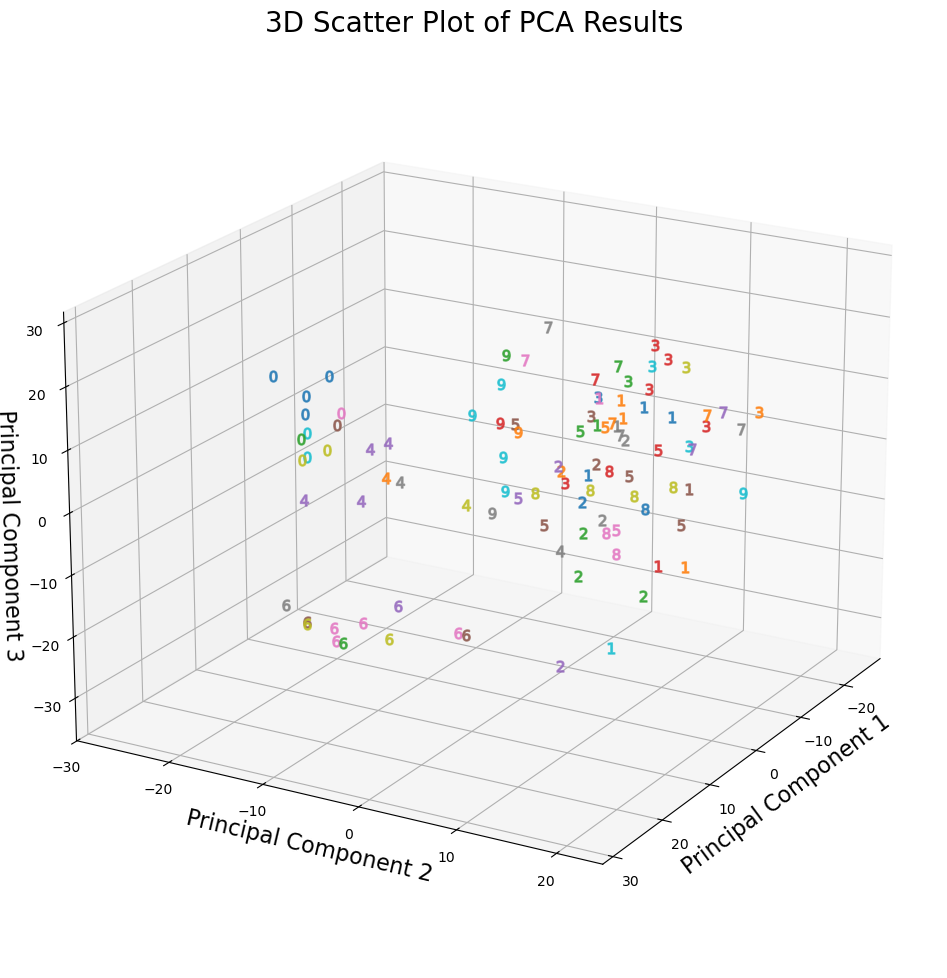

In [84]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a new figure for the 3D scatter plot
fig = plt.figure(figsize=(12, 10))  # Increased figure size
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot with better aesthetics
for i in range(100):
    scatter = ax.scatter(pca_images[i,0], pca_images[i,1], pca_images[i,2],
                      marker=r'${}$'.format(labels[i]), s=64, alpha=0.7)

# Set axis labels with adjusted font size
ax.set_xlabel('Principal Component 1', fontsize=16)
ax.set_ylabel('Principal Component 2', fontsize=16)
ax.set_zlabel('Principal Component 3', fontsize=16)

# Set the title with adjusted font size
ax.set_title('3D Scatter Plot of PCA Results', fontsize=20)

# Adjust viewing angle for better visualization
ax.view_init(elev=20, azim=30)

# Show grid for better readability
ax.grid(True)

# Adjust layout to prevent text clipping
plt.tight_layout(w_pad=1.9)  # Leave space for the title

# Show the plot
plt.show()


### PCA para compresión

A continuación, veremos cómo puede usarse PCA para la **compresión de datos** aplicándolo a una versión de mayor resolución del conjunto de datos MNIST. Obviamente, tras la **reducción de la dimensionalidad**, el conjunto de entrenamiento ocupa mucho menos espacio.

Primero, representemos la **varianza explicada acumulada** frente al **número de dimensiones o componentes principales**.


In [89]:
from sklearn.datasets import fetch_openml

# Let's use a MNIST dataset with higher resolution

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

# Here we take all components
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)


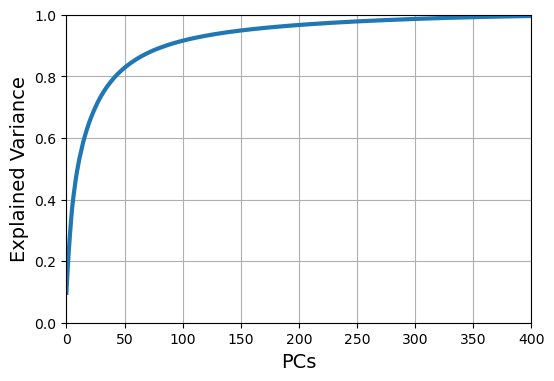

In [96]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("PCs")
plt.ylabel("Explained Variance")
plt.grid(True)

plt.show()

Ahora debemos determinar el número óptimo de **dimensiones** que conservar en un **conjunto de datos**.

Un método heurístico muy usado en **reducción de la dimensionalidad** es el **método del codo**.

El método del codo se basa en que, a medida que aumentan las dimensiones, la **varianza explicada** también crece, normalmente acercándose a 1. Sin embargo, a partir de cierto punto, el incremento de varianza explicada disminuye de forma notable, creando una “forma de codo” en la gráfica. El punto en que se produce esta inflexión señala el **número ideal de dimensiones** a conservar, pues equilibra el compromiso entre capturar suficiente varianza y evitar complejidad innecesaria.

Al identificar este punto de codo, es posible tomar decisiones fundamentadas sobre **cómo reducir la dimensionalidad** de forma eficaz, garantizando que se conserven las **características** más relevantes a la vez que se **simplifica el modelo** para mejorar su rendimiento e interpretabilidad.

Aquí tomamos los componentes suficientes para cubrir el **95 % de la varianza**.


In [94]:
pca = PCA(.95)
X_reduced = pca.fit_transform(X_train)
d = pca.n_components_
print("number of PCs: ", d)
print("preserved variance: ", pca.explained_variance_ratio_.sum() )

number of PCs:  154
preserved variance:  0.9501960192613034


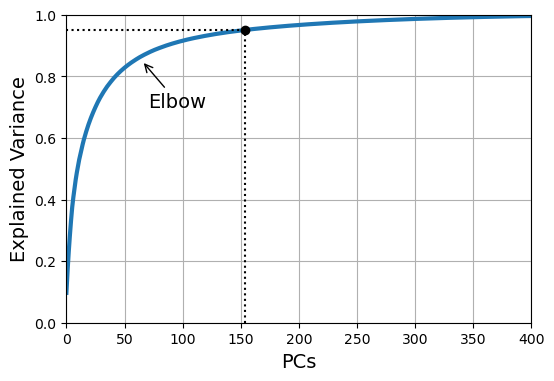

In [95]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("PCs")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)

plt.show()

Finalmente, visualizamos una selección de imágenes originales y reconstruidas lado a lado. Esta comparación demuestra como PCA puede comprimir eficazmente los datos y, aun así, capturar las características esenciales necesarias para la reconstrucción.


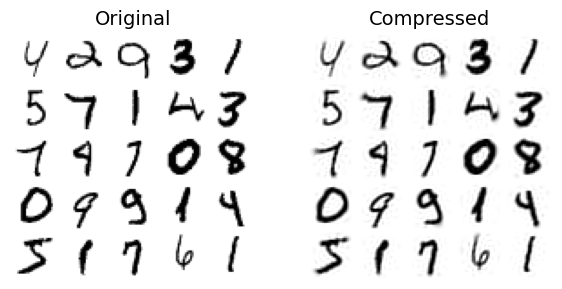

In [88]:
X_recovered = pca.inverse_transform(X_reduced)

plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

plt.show()

In [98]:
def human_readable_size(size):
    """Convert a size in bytes to a human-readable format."""
    for unit in ['B', 'KB', 'MB', 'GB']:
        if size < 1024:
            return f"{size:.2f} {unit}"
        size /= 1024
    return f"{size:.2f} TB"  # for extremely large sizes


In [99]:
# Calculate the original size (number of pixels)
original_size = X_train.shape[0] * X_train.shape[1]  

# Calculate the compressed size
compressed_size = X_reduced.shape[0] * X_reduced.shape[1]  

# Calculate compression ratio
compression_ratio = original_size / compressed_size

print("Original size (pixels):", human_readable_size(original_size))
print("Compressed size (components):", human_readable_size(compressed_size))
print("Compression Ratio:", compression_ratio)


Original size (pixels): 44.86 MB
Compressed size (components): 8.81 MB
Compression Ratio: 5.090909090909091


### Limitaciones de PCA

Aunque el Análisis de Componentes Principales (PCA) es una técnica muy utilizada para la reducción de la dimensionalidad, presenta varias limitaciones que conviene tener en cuenta:

* **Resultado poco interpretable**: Los componentes principales son combinaciones lineales de las características originales, lo que puede dificultar su interpretación. Esta falta de interpretabilidad complica entender la estructura subyacente o las relaciones en los datos.

* **Alto coste computacional**: El cálculo de PCA, especialmente en conjuntos de datos grandes, puede ser costoso. El algoritmo implica operaciones matriciales como la descomposición en autovalores o la Descomposición en Valores Singulares (SVD), lo que supone una carga computacional significativa, sobre todo con datos de alta dimensionalidad.

* **Dificultades con datos en flujo**: PCA se aplica típicamente sobre un conjunto de datos estático, por lo que resulta difícil de usar cuando los datos se generan o actualizan continuamente (p. ej., en *streaming*). Adaptar PCA a actualizaciones por lotes o a muestras del conjunto completo puede complicar el análisis y reducir la eficiencia.

* **Sensibilidad a valores atípicos**: PCA es sensible a los *outliers*, que pueden influir de forma desproporcionada en la orientación de los componentes principales. Esta sensibilidad puede producir resultados engañosos si no se tratan adecuadamente los valores atípicos antes de aplicar PCA.

Estas limitaciones subrayan la importancia de considerar cuidadosamente el contexto y las características de los datos al elegir PCA como método de reducción de la dimensionalidad, y destacan la necesidad de técnicas complementarias en el preprocesamiento y análisis de datos.
